### https://coremltools.readme.io/docs/introductory-quickstart
### https://machinethink.net/blog/mobilenet-ssdlite-coreml/

In [1]:
!ls ../Models/yolo

QuantizedYolov4Tiny4Size320.mlmodel     yolov4-tiny-custom-S4_last.weights
QuantizedYolov4Tiny4Size320v1.mlmodel   yolov4-tiny-custom-S_final_Ori.weights
Quantizedyolov4-tiny4-320.mlmodel       yolov4-tiny3-320.h5
Quantizedyolov4-tiny4.2-320.mlmodel     yolov4-tiny4-320.h5
Quantizedyolov4-tiny4.2.1-320_0.mlmodel yolov4-tiny4-320.mlmodel
Quantizedyolov4-tiny4.2.1-320_1.mlmodel yolov4-tiny4.2-320.h5
labels.txt                              yolov4-tiny4.2-320.mlmodel
yolov4-tiny-416.h5                      yolov4-tiny4.2.1-320.h5
yolov4-tiny-custom-S2_last.weights      yolov4-tiny4.2.1-320_0.mlmodel
yolov4-tiny-custom-S3_last.weights      yolov4-tiny4.2.1-320_1.mlmodel
yolov4-tiny-custom-S4.2_last.weights


In [2]:
import tensorflow as tf
import coremltools as ct
import numpy as np
from tensorflow.keras.models import Model

model_name = "yolov4-tiny4.2.1-320"

keras_model_loaded = tf.keras.models.load_model("../Models/yolo/" + model_name + ".h5", compile=False)
input_image = tf.keras.layers.Input(shape=(320, 320, 3), name="image")
pred_bbox = keras_model_loaded(input_image)

keras_model_0 = tf.keras.Model(inputs=[input_image], outputs=[pred_bbox])
keras_model_0.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    [(None, None, 4), (None,  94880     
Total params: 94,880
Trainable params: 94,104
Non-trainable params: 776
_________________________________________________________________


In [3]:
model_0 = ct.convert(
    keras_model_0, 
    inputs=[ct.ImageType(scale=1/255.0)],
)

spec = model_0.get_spec()
                        
# Edit the spec
ct.utils.rename_feature(spec, 'Identity', 'class_boxes')
ct.utils.rename_feature(spec, 'Identity_1', 'pred_conf')
ct.utils.rename_feature(spec, 'Identity_2', 'scores_max')

# reload the model with the updated spec and re-save
model_0 = ct.models.MLModel(spec)

Translating MIL ==> MLModel Ops: 100%|███████████████████████| 493/493 [00:00<00:00, 22116.60 ops/s]


In [4]:
box_xywh = tf.keras.layers.Input(shape=(None, 4), name="class_boxes")
scores = tf.keras.layers.Input(shape=(None, 1), name="pred_conf")

scores_max = tf.math.reduce_max(scores, axis=-1)

mask = scores_max >= 0.4
class_boxes = tf.boolean_mask(box_xywh, mask)
pred_conf = tf.boolean_mask(scores, mask)
class_boxes = tf.reshape(class_boxes, [tf.shape(scores)[0], -1, tf.shape(class_boxes)[-1]])
pred_conf = tf.reshape(pred_conf, [tf.shape(scores)[0], -1, tf.shape(pred_conf)[-1]])

box_xy, box_wh = tf.split(class_boxes, (2, 2), axis=-1)

box_yx = box_xy[..., ::-1]
box_hw = box_wh[..., ::-1]

box_mins = (box_yx - (box_hw / 2.)) / tf.constant([320.0,320.0])
box_maxes = (box_yx + (box_hw / 2.)) / tf.constant([320.0,320.0])
boxes = tf.concat([
    box_mins[..., 0:1],  # y_min
    box_mins[..., 1:2],  # x_min
    box_maxes[..., 0:1],  # y_max
    box_maxes[..., 1:2]  # x_max
    ], axis=-1)
boxes = tf.reshape(boxes, (-1, 4))
conf = tf.reshape(pred_conf, (-1, 1))
keras_model_1 = tf.keras.Model(inputs=[box_xywh, scores], outputs=[boxes, conf])
# keras_model_1.summary()

model_1 = ct.convert(
    keras_model_1, 
)

output_sizes = [4, 1]
for i in range(2):
    ma_type = model_1._spec.description.output[i].type.multiArrayType
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[0].lowerBound = 0
    ma_type.shapeRange.sizeRanges[0].upperBound = -1
    ma_type.shapeRange.sizeRanges.add()
    ma_type.shapeRange.sizeRanges[1].lowerBound = output_sizes[i]
    ma_type.shapeRange.sizeRanges[1].upperBound = output_sizes[i]
    del ma_type.shape[:]

Translating MIL ==> MLModel Ops: 100%|███████████████████████| 100/100 [00:00<00:00, 35833.44 ops/s]


In [5]:
nms_spec = ct.proto.Model_pb2.Model()
nms_spec.specificationVersion = 5
for i in range(2):
    decoder_output = model_1._spec.description.output[i].SerializeToString()
    nms_spec.description.input.add()
    nms_spec.description.input[i].ParseFromString(decoder_output)
    nms_spec.description.output.add()
    nms_spec.description.output[i].ParseFromString(decoder_output)
    
nms_spec.description.output[0].name = "coordinates"
nms_spec.description.output[1].name = "confidence"
    
nms = nms_spec.nonMaximumSuppression
nms.confidenceInputFeatureName = "Identity_1"
nms.coordinatesInputFeatureName = "Identity"
nms.confidenceOutputFeatureName = "confidence"
nms.coordinatesOutputFeatureName = "coordinates"
nms.iouThresholdInputFeatureName = "iouThreshold"
nms.confidenceThresholdInputFeatureName = "confidenceThreshold"

default_iou_threshold = 0.5
default_confidence_threshold = 0.5
nms.iouThreshold = default_iou_threshold
nms.confidenceThreshold = default_confidence_threshold
nms.pickTop.perClass = True

labels = np.loadtxt("labels.txt", dtype=str, delimiter="\n")
if labels.ndim == 0:
    labels = np.array([labels])
nms.stringClassLabels.vector.extend(labels)

nms_model = ct.models.MLModel(nms_spec)

In [6]:
from coremltools.models import datatypes
from coremltools.models.pipeline import *
input_features = [ ("class_boxes", datatypes.Array(-1, 4)),
                   ("pred_conf", datatypes.Array(-1, 1)),
                   ("iouThreshold", datatypes.Double()),
                   ("confidenceThreshold", datatypes.Double()) ]

output_features = [ "confidence", "coordinates" ]

pipeline = Pipeline(input_features, output_features)

pipeline.add_model(model_1)
pipeline.add_model(nms_model)

pipeline.spec.description.input[0].ParseFromString(
    model_1._spec.description.input[0].SerializeToString())
pipeline.spec.description.input[1].ParseFromString(
    model_1._spec.description.input[1].SerializeToString())
pipeline.spec.description.output[0].ParseFromString(
    nms_model._spec.description.output[0].SerializeToString())
pipeline.spec.description.output[1].ParseFromString(
    nms_model._spec.description.output[1].SerializeToString())

user_defined_metadata = {
    "iou_threshold": str(default_iou_threshold),
    "confidence_threshold": str(default_confidence_threshold),
    "classes": ",".join(labels)
}
pipeline.spec.description.metadata.userDefined.update(user_defined_metadata)

In [7]:
# Save model
# model.save("../Models/yolo/yolov4-tiny-416.mlmodel") 
model_1 = ct.models.MLModel(pipeline.spec)

model_0.save("../Models/yolo/" + model_name + "_0.mlmodel")
# Load a saved model
loaded_model_0 = ct.models.MLModel("../Models/yolo/" + model_name + "_0.mlmodel")

model_1.save("../Models/yolo/" + model_name + "_1.mlmodel")
# Load a saved model
loaded_model_1 = ct.models.MLModel("../Models/yolo/" + model_name + "_1.mlmodel")

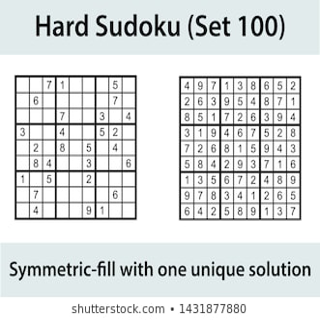

In [8]:
from PIL import Image
import numpy as np
# example_image = Image.fromarray(np.ones((320, 320)))
# example_image = example_image.resize((320,320)).convert('RGB')

# example_image = Image.open("../Datasets/ss1.PNG").resize((320,320)).convert('RGB')
# example_image = Image.open("../Datasets/69BBA451-7229-48CD-988D-87532809E331.jpeg").resize((320,320)).convert('RGB')

example_image = Image.open("../Datasets/vector-sudoku-puzzle-solution-hard-260nw-1431877880.jpg").resize((320,320)).convert('RGB')

example_image

In [9]:
# Make a prediction using Core ML
out_dict = loaded_model_0.predict({"image": example_image}, usesCPUOnly=False)
out_dict
# loaded_model_1.predict({"class_boxes": out_dict['class_boxes'],
#                         "pred_conf": out_dict['pred_conf'],
#                        "iouThreshold": 0.5, "confidenceThreshold": 0.5}, usesCPUOnly=False)

{'scores_max': array([0.96970564], dtype=float32),
 'class_boxes': array([[[ 11.9652195,  11.169098 , 245.27606  , 125.710144 ],
         [ 12.665116 ,  11.534476 , 221.87701  , 213.03012  ],
         [ 13.338507 ,   5.43204  , 221.44768  , 298.49866  ],
         ...,
         [296.9596   , 295.27176  , 332.6926   , 189.10931  ],
         [298.76837  , 302.72177  , 246.22118  , 333.7491   ],
         [298.46613  , 298.55136  , 313.58218  , 347.40826  ]]],
       dtype=float32),
 'pred_conf': array([[[2.0864643e-07],
         [5.9388549e-07],
         [1.8987319e-06],
         ...,
         [4.8263502e-08],
         [1.1795822e-07],
         [1.3884674e-07]]], dtype=float32)}

# Quantization

https://apple.github.io/coremltools/generated/coremltools.models.neural_network.quantization_utils.html

In [10]:
from coremltools.models.neural_network import quantization_utils
quantized_model_0 = quantization_utils.quantize_weights(loaded_model_0, 8, "linear")
quantized_model_0.save("../Models/yolo/Quantized" + model_name + "_0.mlmodel")

quantized_model_1 = quantization_utils.quantize_weights(loaded_model_1, 8, "linear")
quantized_model_1.save("../Models/yolo/Quantized" + model_name + "_1.mlmodel")

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Fused functional_1/functional_1/conv2d/Conv2Dx->batch_norm_0
Fused functional_1/functional_1/conv2d_1/Conv2Dx->batch_norm_1
Fused functional_1/functional_1/conv2d_2/Conv2Dx->batch_norm_2
Fused functional_1/functional_1/conv2d_3/Conv2Dx->batch_norm_3
Fused functional_1/functional_1/conv2d_4/Conv2Dx->batch_norm_4
Fused functional_1/functional_1/conv2d_5/Conv2Dx->batch_norm_5
Fused functional_1/functional_1/conv2d_6/Conv2Dx->batch_norm_6
Fused functional_1/functional_1/conv2d_7/Conv2Dx->batch_norm_7
Fused functional_1/functional_1/conv2d_8/Conv2Dx->batch_norm_8
Fused functional_1/functional_1/conv2d_9/Conv2Dx->batch_norm_9
Fused functional_1/functional_1/conv2d_10/Conv2Dx->batch_norm_10
Fused functional_1/functional_1/conv2d_11/Conv2Dx->batch_norm_11
Fused functional_1/functional_1/conv2d_12/Conv2Dx->batch_norm_12
Fused functional_1/functional_1/conv2d_13/Conv2Dx->batch_norm_13
Fused functional_1/functiona

In [11]:
# Make a prediction using Core ML
out_dict_0 = quantized_model_0.predict({"image": example_image}, usesCPUOnly=False)

out_dict = quantized_model_1.predict({"class_boxes": out_dict_0['class_boxes'],
                        "pred_conf": out_dict_0['pred_conf'],
                       "iouThreshold": 0.5, "confidenceThreshold": 0.5}, usesCPUOnly=False)

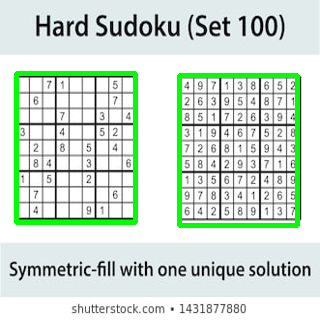

In [12]:
import cv2
img = np.array(example_image)

for i in range(out_dict['coordinates'].shape[0]):
    cv2.rectangle(img, 
                  (int(320*out_dict['coordinates'][i][0]), int(320*out_dict['coordinates'][i][1])), 
                  (int(320*out_dict['coordinates'][i][2]), int(320*out_dict['coordinates'][i][3])),
                  (0, 255, 0), 3)
Image.fromarray(img)